# Estimating Indirect Nutrient Load from PT

# Imports

In [1]:
# Standard libraries
import os
import glob
import warnings
import gc

# Data manipulation and analysis libraries
import numpy as np
import pandas as pd
import dask.dataframe as dd
import dask.array as da
import xarray as xr
import geopandas as gpd
from shapely.geometry import Point
from netCDF4 import Dataset
# geopandas 
from shapely.geometry import Point
import geopandas as gpd

# Dask diagnostics and progress bar
from dask.diagnostics import ProgressBar

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap, LogNorm
import cartopy.crs as ccrs
from pylag.processing.plot import FVCOMPlotter, create_figure, colourmap

# Helper Function 

In [2]:
# Define the function to sort the files based on the time
def sort_key(file):
    filename = os.path.basename(file)
    try:
        # Extract the number after the double underscores and before the `.nc` extension
        number = int(filename.split('_')[-1].split('.')[0])
        return number
    except (IndexError, ValueError):
        # Handle filenames that do not match the pattern by returning a high number to place them last
        return float('inf')

# Inputs

In [3]:
# Define paths for coastal wetland shapefiles
GIS_LAYERS = '/home/abolmaal/Data/GIS_layer'  # Add leading slash to make it an absolute path
CW_path = os.path.join(GIS_LAYERS, 'Coastalwetland/hitshoreline')

#CW_path = '/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/GIS_layer/Coastalwetland/hitshoreline/'

# Paths to specific coastal wetland shapefiles with different inundation levels that have 50 meter buffer from the shoreline
CW_avg_path = os.path.join(CW_path, 'Wetland_connected_avg_inundation_NAD1983_shorelineinteraction_50m_ExportFeatures.shp')
CW_low_path = os.path.join(CW_path, 'wetlands_connected_low_inundation_NAD1983_shorelineinteraction_50m_ExportFeatures.shp')
CW_high_path = os.path.join(CW_path, 'wetlands_connected_high_inundation_NAD1983_shorelineinteraction_50m_ExportFeatures.shp')
CW_surge_path = os.path.join(CW_path, 'wetlands_connected_surge_inundation_NAD1983_shorelineinteraction_50m_ExportFeatures.shp')

# Load coastal wetland shapefiles as GeoDataFrames
CW_avg = gpd.read_file(CW_avg_path)
CW_low = gpd.read_file(CW_low_path)
CW_high = gpd.read_file(CW_high_path)
CW_surge = gpd.read_file(CW_surge_path)

# Define the path to FVCOM model output files
data_dir = '/home/abolmaal/modelling/FVCOM/Huron/output'
files = glob.glob(os.path.join(data_dir, "updated_FVCOM_Huron_2323_*.nc"))
files.sort(key=sort_key)
# Define the path to the FVCOM grid metrics file
grid_metrics_file_name = '/home/abolmaal/modelling/FVCOM/Huron/input/gridfile/grid_metrics_huron_senseflux_Seasonal.nc'


# Path to nutrient load data CSV and load the CSV
Direct_Nutrient_load = '/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/ZonalStats/StreamWatresheds_total_N_P.csv'
Direct_Nutrient = pd.read_csv(Direct_Nutrient_load)

# Check and rename columns in the CSV file to match NetCDF data requirements
required_columns = {'Group_id': 'group_id', 'WetLoad_TN_kgcellday': 'WetLoad_TN_kgcellday', 'WetLoad_TP_kgcellday': 'WetLoad_TP_kgcellday'}

# Outputs

In [4]:
output_path = '/home/abolmaal/modelling/FVCOM/Huron/results'
output_figures = '/home/abolmaal/modelling/FVCOM/Huron/figures/2024'

# Define the file names to the FVCOM model output
originalFVCOM = 'LakeHuronparticletracking_2023_original.shp'


# file name for Intersected FVCOM model output with coastal wetlands

Intersection_PTCW_Avg = 'Intersections_Avg_PTCW_23.csv'
Intersection_PTCW_high = 'Intersections_high_PTCW_23.csv'
Intersection_PTCW_low = 'Intersections_low_PTCW_23.csv'
Intersection_PTCW_surge = 'Intersections_surge_PTCW_23.csv'

# monthly average of the Intersected FVCOM model output with coastal wetlands
Intersection_PTCW_Avg_monthly = 'Intersections_Avg_PTCW_monthly_23.csv'
Intersection_PTCW_high_monthly = 'Intersections_high_PTCW_monthly_23.csv'
Intersection_PTCW_low_monthly = 'Intersections_low_PTCW_monthly_23.csv'
Intersection_PTCW_surge_monthly = 'Intersections_surge_PTCW_monthly_23.csv'
###################################################################
GroupIdcount = 'group_id_counts.csv'
Non_Intersection_avg = 'Non_Intersection_avg.csv'
Non_Intersection_high = 'Non_Intersection_high.csv'
Non_Intersection_low = 'Non_Intersection_low.csv'
Non_Intersection_surge = 'Non_Intersection_surge.csv'

In [5]:

# file name for Intersected FVCOM model output with coastal wetlands

Intersection_PTCW_Avg = 'Intersection_PTCW_Avg_test_23.csv'
Intersection_PTCW_high = 'Intersection_PTCW_High_test_23.csv'
Intersection_PTCW_low = 'Intersection_PTCW_Low_test_23.csv'
Intersection_PTCW_surge = 'Intersection_PTCW_Surge_test_23.csv'

# monthly average of the Intersected FVCOM model output with coastal wetlands
Intersection_PTCW_Avg_monthly = 'Intersection_PTCW_Avg_monthly_test_23.csv'
Intersection_PTCW_high_monthly = 'Intersection_PTCW_High_monthly_test_23.csv'
Intersection_PTCW_low_monthly = 'Intersection_PTCW_Surge_monthly_test_23.csv'
Intersection_PTCW_surge_monthly = 'Intersection_PTCW_Surge_monthly_test_23.csv'

# Parameters

In [96]:
# Figure parameters
# Custom colormap setup (pink and blue shades)
pink_shades = ['#fff5f7', '#ffebf0', '#ffd6e1', '#ffbfd4', '#ff99c1', '#ff6ea9', '#ff4c92', '#ff2171', '#b50d4e']
blue_shades = ['#f7fbff', '#deebf7', '#c6dbef', '#9ecae1', '#6baed6', '#4292c6', '#2171b5', '#084594']
blue_shades_reversed = blue_shades[::-1]

pink_cmap = LinearSegmentedColormap.from_list('custom_pink', pink_shades)
blue_cmap_reversed = LinearSegmentedColormap.from_list('custom_blue', blue_shades)

# Define a list of green shades for the colormap
green_shades =  ['#e0ffe0', '#b3ffb3', '#80ff80', '#4dff4d', '#00e600', '#00cc00', '#009900', '#006600', '#003300']
# Create a custom green colormap
green_cmap = LinearSegmentedColormap.from_list('custom_green', green_shades)

# Replace pink_cmap with viridis and plasma
viridis_cmap = plt.colormaps['viridis']  # Updated to use new interface
plasma_cmap = plt.colormaps['plasma']  # Updated to use new interface
reversed_plasma_cmap = plasma_cmap.reversed()  # Reversed colormap  
# Set up plotting parameters
font_size = 15
cmap = plt.colormaps['hsv_r']  # Fixed: using an existing colormap (hsv_r)

# Extent of the plot
extents = np.array([275, 277.69, 43, 46.3], dtype=float)

extents_ausable = np.array([276.5, 276.8, 45, 45.5], dtype=float)

# Some parameters for the Zonal Stats Fields
# Fields to calculate / Direct delivery to Watersheds
fieldDirectTN = 'WetLoad_TN_kgcellday'
fieldDirectTP = 'WetLoad_TP_kgcellday'

# Main Functions


## Create a geodatafram from the particle tracking outputs

In [6]:
import geopandas as gpd
import numpy as np
import pandas as pd
from dask.delayed import delayed
import xarray as xr
from shapely.geometry import Point
import dask  # Import Dask to access dask.compute
from dask import compute  # Import the specific compute function
import gc  # To manually collect garbage and free up memory
from dask.distributed import Client


# Limit the number of workers and threads
client = Client(n_workers=2, threads_per_worker=2)  # Adjust as needed

print(client)
# Function to remove overlap in time
def remove_overlap(datasets):
    # Remove the first time step of each dataset except for the first one
    datasets[1:] = [ds.sel(time=slice(ds['time'][1], None)) for ds in datasets[1:]]
    return datasets

# Function to process a single file and convert to GeoDataFrame
@delayed
def process_file(file):
    # Open the dataset lazily with xarray (no data loaded yet)
    with xr.open_dataset(file) as ds:
        selected_vars = ds[['time', 'group_id', 'group_number', 'longitude', 'latitude']]

        # Perform operations like longitude correction
        selected_vars['longitude'].values = np.where(selected_vars['longitude'].values > 180, 
                                                     selected_vars['longitude'].values - 360, 
                                                     selected_vars['longitude'].values)

        # Convert xarray to pandas dataframe
        PT_df = selected_vars.to_dataframe().reset_index()

        # Create GeoDataFrame from the DataFrame
        PT_gdf = gpd.GeoDataFrame(PT_df, geometry=gpd.GeoSeries.from_xy(PT_df['longitude'], PT_df['latitude']))

        # Set the CRS and reproject if necessary
        PT_gdf.set_crs('EPSG:4326', inplace=True, allow_override=True)
        PT_gdf = PT_gdf.to_crs('EPSG:3174')

        # Release memory after processing the dataset
        del ds, selected_vars, PT_df  # Delete variables no longer needed
        gc.collect()  # Force garbage collection to release memory

        return PT_gdf

# Use dask.delayed to process each file (process files in smaller batches to avoid memory overload)
batch_size = 2  # Process in smaller batches of 2 files at a time
batches = [files[i:i + batch_size] for i in range(0, len(files), batch_size)]

all_gdfs = []

# Process each batch separately
for batch in batches:
    all_delayed = [process_file(file) for file in batch]
    batch_gdfs = compute(*all_delayed)  # Use dask.compute here
    all_gdfs.extend(batch_gdfs)  # Append the GeoDataFrames from this batch

    # Manually trigger garbage collection after each batch to release memory
    gc.collect()

# Now combine the GeoDataFrames from all batches into one
final_gdf = pd.concat(all_gdfs, ignore_index=True)

# Set final CRS if necessary
#final_gdf.set_crs('EPSG:4326', inplace=True, allow_override=True)
#final_gdf = final_gdf.to_crs('EPSG:3174')

# Final GeoDataFrame with all datasets
print(final_gdf)

<Client: 'tcp://127.0.0.1:33261' processes=2 threads=4, memory=15.62 GiB>
               time  particles  group_id group_number  longitude   latitude  \
0        2023-01-01          0         0        00000 -84.666107  45.742802   
1        2023-01-01          1         0        00001 -84.664886  45.742802   
2        2023-01-01          2         0        00002 -84.663696  45.742802   
3        2023-01-01          3         0        00003 -84.662506  45.742802   
4        2023-01-01          4         0        00004 -84.661285  45.742802   
...             ...        ...       ...          ...        ...        ...   
22768645 2023-12-29       8545       162       162070 -83.772247  43.635368   
22768646 2023-12-29       8546       162       162071 -83.772064  43.635319   
22768647 2023-12-29       8547       162       162072 -83.772156  43.635338   
22768648 2023-12-29       8548       162       162073 -83.739326  43.625008   
22768649 2023-12-29       8549       162       162074 -83

In [7]:
PT_gdf = final_gdf

# Calculated monthly Intersection Seperately for each month 

In [ ]:
import os
import pandas as pd
import geopandas as gpd
import gc

def calculate_monthly_first_intersections(gdf, CW_avg, output_path, output_csv="Intersection_PTCW_Avg.csv", summary_csv="Intersection_PTCW_Avg_monthly.csv"):
    """
    Loop through each month in the dataset, find only the first intersection per particle, 
    and save the results to a single CSV file. Also calculates the percentage of 
    intersecting particles per month.

    Parameters:
    - gdf: GeoDataFrame with 'time', 'group_id', 'group_number', 'geometry'
    - CW_avg: GeoDataFrame representing the wetland shapefile
    - output_path: Directory where the CSV files should be saved
    - output_csv: Optional output CSV filename (default is "Intersection_PTCW_Avg.csv")
    - summary_csv: Optional summary CSV filename (default is "Intersection_PTCW_Avg_monthly.csv")

    Returns:
    - monthly_first_intersections_df: DataFrame of first-time intersections
    - summary_stats_df: DataFrame of intersection percentages per month
    """
    # Reset index if needed
    if 'time' in gdf.index.names:
        print("🔄 Resetting 'time' from index to column...")
        gdf = gdf.reset_index()

    if 'time' not in gdf.columns:
        print("❌ ERROR: 'time' column is missing!")
        return None, None

    gdf['time'] = pd.to_datetime(gdf['time'], errors='coerce')

    # Ensure CRS matches
    if gdf.crs != CW_avg.crs:
        print("🔄 Reprojecting gdf to match CW_avg CRS...")
        gdf = gdf.to_crs(CW_avg.crs)

    # Extract month
    gdf['month'] = gdf['time'].dt.to_period("M")

    # Precompute wetland union geometry using union_all() (no deprecation warning)
    wetland_union = CW_avg.geometry.union_all()

    # Initialize storage for results
    monthly_results = []
    summary_stats = []

    # Loop over each unique month
    unique_months = sorted(gdf['month'].unique())
    for month in unique_months:
        print(f"📅 Processing {month}...")

        monthly_gdf = gdf[gdf['month'] == month]
        total_particles = monthly_gdf[['group_id', 'group_number']].drop_duplicates().shape[0]

        # Find intersecting particles
        intersecting_particles = monthly_gdf[monthly_gdf['geometry'].intersects(wetland_union)]

        if not intersecting_particles.empty:
            # Find the first intersection per particle (by time)
            first_intersections = (
                intersecting_particles
                .sort_values(by=['group_id', 'group_number', 'time'])
                .groupby(['group_id', 'group_number'])
                .first()
                .reset_index()
            )

            total_first = first_intersections.shape[0]
            percentage = (total_first / total_particles) * 100 if total_particles > 0 else 0

            print(f"✅ {month}: {total_first} particles first-time intersected ({percentage:.2f}%)")

            first_intersections['month'] = str(month)

            # Perform spatial join to include relevant columns from CW_avg
            joined_gdf = gpd.sjoin(first_intersections, CW_avg, how='left', op='intersects')

            monthly_results.append(joined_gdf)
            summary_stats.append({'month': str(month), 'percentage': percentage})
        else:
            print(f"⚠️ {month}: No intersections found.")

        # Free memory after each month's processing
        del monthly_gdf, intersecting_particles, first_intersections, joined_gdf
        gc.collect()

    # Combine all results
    if monthly_results:
        monthly_first_intersections_df = pd.concat(monthly_results, ignore_index=True)
    else:
        monthly_first_intersections_df = pd.DataFrame()

    # Convert summary list to DataFrame
    summary_stats_df = pd.DataFrame(summary_stats)

    # Save both DataFrames to CSV in the provided output path
    # Save the first intersections data
    output_file = os.path.join(output_path, output_csv)
    monthly_first_intersections_df.to_csv(output_file, index=False)
    print(f"✅ Monthly first-time intersections saved to {output_file}")

    # Save the summary stats data
    summary_output_file = os.path.join(output_path, summary_csv)
    summary_stats_df.to_csv(summary_output_file, index=False)
    print(f"✅ Summary statistics saved to {summary_output_file}")

    # Return the results
    return monthly_first_intersections_df, summary_stats_df

## Steps to Modify the Code:
Create a unique identifier for each particle: This identifier will be based on group_id and particle_index.

Track particles that have already intersected: Once a particle has intersected in a month, we will add its identifier to a set so that it is not counted again in subsequent months.

Only count the first intersection for each unique particle: We'll ensure that if a particle intersects multiple months, we only pick the first intersection.

In [8]:
import os
import pandas as pd
import geopandas as gpd
import gc

def calculate_monthly_first_intersections(gdf, CW_avg, output_path, output_csv="Intersection_PTCW_Avg_test.csv", summary_csv="Intersection_PTCW_Avg_monthly_test.csv"):
    """
    Loop through each month in the dataset, find only the first intersection per particle, 
    and save the results to a single CSV file. Also calculates the percentage of 
    intersecting particles per month.

    Parameters:
    - gdf: GeoDataFrame with 'time', 'group_id', 'group_number', 'geometry'
    - CW_avg: GeoDataFrame representing the wetland shapefile
    - output_path: Directory where the CSV files should be saved
    - output_csv: Optional output CSV filename (default is "Intersection_PTCW_Avg.csv")
    - summary_csv: Optional summary CSV filename (default is "Intersection_PTCW_Avg_monthly.csv")

    Returns:
    - monthly_first_intersections_df: DataFrame of first-time intersections
    - summary_stats_df: DataFrame of intersection percentages per month
    """
    
    # Reset index if needed
    if 'time' in gdf.index.names:
        print("🔄 Resetting 'time' from index to column...")
        gdf = gdf.reset_index()

    if 'time' not in gdf.columns:
        print("❌ ERROR: 'time' column is missing!")
        return None, None

    gdf['time'] = pd.to_datetime(gdf['time'], errors='coerce')

    # Ensure CRS matches
    if gdf.crs != CW_avg.crs:
        print("🔄 Reprojecting gdf to match CW_avg CRS...")
        gdf = gdf.to_crs(CW_avg.crs)

    # Extract month
    gdf['month'] = gdf['time'].dt.to_period("M")

    # Precompute wetland union geometry using union_all() (no deprecation warning)
    wetland_union = CW_avg.geometry.union_all()

    # Initialize storage for results
    monthly_results = []
    summary_stats = []
    
    # Track particles that have already been counted (set of unique group_idparticle_index)
    counted_particles = set()

    # Keep track of the first intersections across all months
    first_intersections_across_months = set()

    # Loop over each unique month
    unique_months = sorted(gdf['month'].unique())
    for month in unique_months:
        print(f"📅 Processing {month}...")

        monthly_gdf = gdf[gdf['month'] == month]
        total_particles = monthly_gdf[['group_id', 'group_number']].drop_duplicates().shape[0]

        # Find intersecting particles
        intersecting_particles = monthly_gdf[monthly_gdf['geometry'].intersects(wetland_union)]

        if not intersecting_particles.empty:
            intersecting_particles = intersecting_particles.copy()
            intersecting_particles['group_idparticle_index'] = (
                intersecting_particles['group_id'].astype(str) + 
                '_' + intersecting_particles['group_number'].astype(str)
            )

            # Filter out particles that have already been counted (those appearing in previous months)
            new_particles = intersecting_particles[~intersecting_particles['group_idparticle_index'].isin(first_intersections_across_months)]

            # Find the first intersection for each group_idparticle_index in the current month
            first_intersections = (
                new_particles
                .sort_values(by=['group_id', 'group_number', 'time'])
                .drop_duplicates(subset='group_idparticle_index', keep='first')
                .reset_index(drop=True)
            )

            total_first = first_intersections.shape[0]
            percentage = (total_first / total_particles) * 100 if total_particles > 0 else 0

            print(f"✅ {month}: {total_first} particles first-time intersected ({percentage:.2f}%)")

            first_intersections['month'] = str(month)

            # Add the particles from the current month to the tracked particles across all months
            first_intersections_across_months.update(first_intersections['group_idparticle_index'])

            # Check if the CRS is set, and if not, set it from `gdf` or default to CRS of `CW_avg`
            if first_intersections.crs is None:
                print("🔄 Setting CRS for first_intersections...")
                first_intersections.set_crs(gdf.crs, allow_override=True, inplace=True)

            # Ensure the CRS of first_intersections matches CW_avg's CRS
            if first_intersections.crs != CW_avg.crs:
                print("🔄 Reprojecting first_intersections to match CW_avg CRS...")
                first_intersections = first_intersections.to_crs(CW_avg.crs)

            # Perform spatial join to include relevant columns from CW_avg
            joined_gdf = gpd.sjoin(first_intersections, CW_avg, how='left', predicate='intersects')

            monthly_results.append(joined_gdf)
            summary_stats.append({'month': str(month), 'percentage': percentage})
        else:
            print(f"⚠️ {month}: No intersections found.")

        # Free memory after each month's processing
        del monthly_gdf, intersecting_particles, first_intersections, joined_gdf
        gc.collect()

    # Combine all results
    if monthly_results:
        monthly_first_intersections_df = pd.concat(monthly_results, ignore_index=True)
    else:
        monthly_first_intersections_df = pd.DataFrame()

    # Convert summary list to DataFrame
    summary_stats_df = pd.DataFrame(summary_stats)

    # Save both DataFrames to CSV in the provided output path
    # Save the first intersections data
    output_file = os.path.join(output_path, output_csv)
    monthly_first_intersections_df.to_csv(output_file, index=False)
    print(f"✅ Monthly first-time intersections saved to {output_file}")

    # Save the summary stats data
    summary_output_file = os.path.join(output_path, summary_csv)
    summary_stats_df.to_csv(summary_output_file, index=False)
    print(f"✅ Summary statistics saved to {summary_output_file}")

    # Return the results
    return monthly_first_intersections_df, summary_stats_df


### Set projrctions

In [16]:
#set the crs of cw_avg to 3174
CW_avg.to_crs('EPSG:3174', inplace=True)
CW_low.to_crs('EPSG:3174', inplace=True)
CW_high.to_crs('EPSG:3174', inplace=True)
CW_surge.to_crs('EPSG:3174', inplace=True)

In [17]:
CW_avg

,ID,GRIDCODE,Wetland,Shape_Area,Shape_Len,start_lat,start_lon,geometry
0,4592,15,Emergent Wetland,1.226935e+05,2132.422988,45.564909,-84.130356,"POLYGON ((1025405.999 999482.975, 1025393.537 ..."
1,5730,15,Emergent Wetland,1.037015e+06,11976.973780,45.556107,-84.125917,"POLYGON ((1025700.906 998430.678, 1025688.444 ..."
2,5833,15,Emergent Wetland,8.403687e+03,410.115930,45.553651,-84.126473,"POLYGON ((1025667.819 998329.007, 1025666.744 ..."
3,6245,15,Emergent Wetland,1.899233e+05,3201.142242,45.550923,-84.126687,"POLYGON ((1025701.233 997841.782, 1025676.31 9..."
4,7596,15,Emergent Wetland,2.689179e+04,902.078084,45.535541,-84.125815,"POLYGON ((1025767.843 996290.941, 1025755.381 ..."
...,...,...,...,...,...,...,...,...
4362,1444707,14,Aquatic Bed,1.009568e+04,410.129710,43.068481,-82.463392,"POLYGON ((1162164.235 723741.082, 1162126.791 ..."
4363,1444803,17,Typha,1.009568e+04,410.263812,43.068317,-82.463004,"POLYGON ((1162190.254 723717.134, 1162165.291 ..."
4364,1449384,18,Phragmites,1.682619e+03,164.079034,43.057619,-82.454538,"POLYGON ((1162901.921 722557.431, 1162889.439 ..."
4365,1456522,14,Aquatic Bed,3.365252e+03,246.184500,43.043035,-82.446213,"POLYGON ((1163620.119 720947.145, 1163607.637 ..."


In [10]:
PT_gdf.to_crs('EPSG:3174', inplace=True)

## Intersectio with Avg Inun

In [11]:
intersections_df, monthly_percentages_df = calculate_monthly_first_intersections(PT_gdf, CW_avg,output_path,output_csv="Intersection_PTCW_Avg_test_23.csv", summary_csv="Intersection_PTCW_Avg_monthly_test_23.csv")

📅 Processing 2023-01...
✅ 2023-01: 1524 particles first-time intersected (17.82%)
📅 Processing 2023-02...
✅ 2023-02: 280 particles first-time intersected (3.27%)
📅 Processing 2023-03...
✅ 2023-03: 2568 particles first-time intersected (30.04%)
📅 Processing 2023-04...
✅ 2023-04: 241 particles first-time intersected (2.82%)
📅 Processing 2023-05...
✅ 2023-05: 325 particles first-time intersected (3.80%)
📅 Processing 2023-06...
✅ 2023-06: 976 particles first-time intersected (11.42%)
📅 Processing 2023-07...
✅ 2023-07: 925 particles first-time intersected (10.82%)
📅 Processing 2023-08...
✅ 2023-08: 664 particles first-time intersected (7.77%)
📅 Processing 2023-09...
✅ 2023-09: 67 particles first-time intersected (0.78%)
📅 Processing 2023-10...
✅ 2023-10: 22 particles first-time intersected (0.26%)
📅 Processing 2023-11...
✅ 2023-11: 9 particles first-time intersected (0.11%)
📅 Processing 2023-12...
✅ 2023-12: 0 particles first-time intersected (0.00%)
✅ Monthly first-time intersections saved

In [ ]:
intersections_df, monthly_percentages_df = calculate_monthly_first_intersections(PT_gdf, CW_avg,output_path, Intersection_PTCW_Avg, Intersection_PTCW_Avg_monthly)


## High Inundation 

In [ ]:
intersections_df, monthly_percentages_df = calculate_monthly_first_intersections(PT_gdf, CW_high,output_path, Intersection_PTCW_high, Intersection_PTCW_high_monthly)


In [13]:
intersections_df, monthly_percentages_df = calculate_monthly_first_intersections(PT_gdf, CW_high,output_path,output_csv="Intersection_PTCW_High_test_23.csv", summary_csv="Intersection_PTCW_High_monthly_test_23.csv")

📅 Processing 2023-01...
✅ 2023-01: 1553 particles first-time intersected (18.16%)
📅 Processing 2023-02...
✅ 2023-02: 304 particles first-time intersected (3.56%)
📅 Processing 2023-03...
✅ 2023-03: 2782 particles first-time intersected (32.54%)
📅 Processing 2023-04...
✅ 2023-04: 232 particles first-time intersected (2.71%)
📅 Processing 2023-05...
✅ 2023-05: 337 particles first-time intersected (3.94%)
📅 Processing 2023-06...
✅ 2023-06: 1048 particles first-time intersected (12.26%)
📅 Processing 2023-07...
✅ 2023-07: 825 particles first-time intersected (9.65%)
📅 Processing 2023-08...
✅ 2023-08: 591 particles first-time intersected (6.91%)
📅 Processing 2023-09...
✅ 2023-09: 61 particles first-time intersected (0.71%)
📅 Processing 2023-10...
✅ 2023-10: 22 particles first-time intersected (0.26%)
📅 Processing 2023-11...
✅ 2023-11: 10 particles first-time intersected (0.12%)
📅 Processing 2023-12...
✅ 2023-12: 0 particles first-time intersected (0.00%)
✅ Monthly first-time intersections save

## Low Inundation

In [ ]:
intersections_df, monthly_percentages_df = calculate_monthly_first_intersections(PT_gdf, CW_low,output_path, Intersection_PTCW_low, Intersection_PTCW_low_monthly)


In [14]:
intersections_df, monthly_percentages_df = calculate_monthly_first_intersections(PT_gdf, CW_low,output_path,output_csv="Intersection_PTCW_Low_test_23.csv", summary_csv="Intersection_PTCW_Low_monthly_test_23.csv")

📅 Processing 2023-01...
✅ 2023-01: 1434 particles first-time intersected (16.77%)
📅 Processing 2023-02...
✅ 2023-02: 264 particles first-time intersected (3.09%)
📅 Processing 2023-03...
✅ 2023-03: 2335 particles first-time intersected (27.31%)
📅 Processing 2023-04...
✅ 2023-04: 257 particles first-time intersected (3.01%)
📅 Processing 2023-05...
✅ 2023-05: 319 particles first-time intersected (3.73%)
📅 Processing 2023-06...
✅ 2023-06: 887 particles first-time intersected (10.37%)
📅 Processing 2023-07...
✅ 2023-07: 1006 particles first-time intersected (11.77%)
📅 Processing 2023-08...
✅ 2023-08: 702 particles first-time intersected (8.21%)
📅 Processing 2023-09...
✅ 2023-09: 84 particles first-time intersected (0.98%)
📅 Processing 2023-10...
✅ 2023-10: 25 particles first-time intersected (0.29%)
📅 Processing 2023-11...
✅ 2023-11: 10 particles first-time intersected (0.12%)
📅 Processing 2023-12...
✅ 2023-12: 0 particles first-time intersected (0.00%)
✅ Monthly first-time intersections sav

## Surge Inundation 

In [ ]:
intersections_df, monthly_percentages_df = calculate_monthly_first_intersections(PT_gdf, CW_surge,output_path, Intersection_PTCW_surge, Intersection_PTCW_surge_monthly)

In [15]:
intersections_df, monthly_percentages_df = calculate_monthly_first_intersections(PT_gdf, CW_surge,output_path,output_csv="Intersection_PTCW_Surge_test_23.csv", summary_csv="Intersection_PTCW_Surge_monthly_test_23.csv")

📅 Processing 2023-01...
✅ 2023-01: 1576 particles first-time intersected (18.43%)
📅 Processing 2023-02...
✅ 2023-02: 307 particles first-time intersected (3.59%)
📅 Processing 2023-03...
✅ 2023-03: 3025 particles first-time intersected (35.38%)
📅 Processing 2023-04...
✅ 2023-04: 227 particles first-time intersected (2.65%)
📅 Processing 2023-05...
✅ 2023-05: 338 particles first-time intersected (3.95%)
📅 Processing 2023-06...
✅ 2023-06: 1030 particles first-time intersected (12.05%)
📅 Processing 2023-07...
✅ 2023-07: 758 particles first-time intersected (8.87%)
📅 Processing 2023-08...
✅ 2023-08: 559 particles first-time intersected (6.54%)
📅 Processing 2023-09...
✅ 2023-09: 58 particles first-time intersected (0.68%)
📅 Processing 2023-10...
✅ 2023-10: 18 particles first-time intersected (0.21%)
📅 Processing 2023-11...
✅ 2023-11: 9 particles first-time intersected (0.11%)
📅 Processing 2023-12...
✅ 2023-12: 0 particles first-time intersected (0.00%)
✅ Monthly first-time intersections saved

In [17]:
from memory_profiler import profile

@profile
def my_function():
    # Your function here
    pass

## Important Note

The following cells need to be run only **once**. After running them, **reset the kernel** and continue with the following part of the notebook. 

### Steps:
1. Run the cells below.
2. Once completed, reset the kernel:
   - Go to the **Kernel** menu → **Restart Kernel**.
3. After resetting the kernel, continue with the rest of the notebook as usual.

---

This step is necessary to free up memory and ensure that all variables are cleared before proceeding with the next steps.


## empty the memory

In [18]:
# Example: After processing each batch or month
del intersections_df, monthly_percentages_df, PT_gdf  # Delete intermediate variables
gc.collect()  # Manually run garbage collection to free memory

65

# Add NP load to the particles

## Reading the Intersection files

In [76]:
# read the csv files from output path
first_intersections_avgInun = pd.read_csv(os.path.join(output_path, Intersection_PTCW_Avg))
first_intersections_highInun = pd.read_csv(os.path.join(output_path, Intersection_PTCW_high))
first_intersections_lowInun = pd.read_csv(os.path.join(output_path, Intersection_PTCW_low))
first_intersections_surgeInun = pd.read_csv(os.path.join(output_path, Intersection_PTCW_surge))

## Function to merge Intersection with NP Load

In [77]:
def merged_ZonalStats(first_intersections_avgInun, Direct_Nutrient):
    """
    Merges particle tracking data with nutrient load data and adjusts nutrient loads
    based on occurrences of each group_id.

    Parameters:
    - first_intersections_avgInun: DataFrame containing particle tracking data with a 'group_id' column.
    - Direct_Nutrient: DataFrame containing nutrient load data with 'group_id', 'WetLoad_TN_kg2', and 'WetLoad_TP_kg2' columns.

    Returns:
    - merged_data: DataFrame with merged data and adjusted 'WetLoad_TN_kg2' and 'WetLoad_TP_kg2' values.
    - returns the wetload values divided by the group_id counts the get the values for each group_id count
    """
    
    # Step 1: Count occurrences of each group_id in the NetCDF file and store as a dictionary
    group_id_counts = first_intersections_avgInun['group_id'].value_counts().to_dict()
    
    # Step 2: Merge particle data with nutrient load data
    merged_data = pd.merge(first_intersections_avgInun, Direct_Nutrient, on='group_id', how='left')
    
    # Step 3: Adjust WetLoad_TN_kg2 and WetLoad_TP_kg2 values by dividing by group_id count
    merged_data[fieldDirectTN] = merged_data.apply(
        lambda row: row[fieldDirectTN] / group_id_counts[row['group_id']] if pd.notnull(row[fieldDirectTN]) else None,
        axis=1
    )

    merged_data[fieldDirectTN] = merged_data.apply(
        lambda row: row[fieldDirectTN] / group_id_counts[row['group_id']] if pd.notnull(row[fieldDirectTN]) else None,
        axis=1
    )
    merged_data[fieldDirectTP] = merged_data.apply(
        lambda row: row[fieldDirectTP] / group_id_counts[row['group_id']] if pd.notnull(row[fieldDirectTP]) else None,
        axis=1
    )
    # drop unnecessary columns
    #merged_data.drop(columns=['index_right','ID','GRIDCODE','start_lat','start_lon'], inplace=True)
    return merged_data

## merging the Intersections for different lake levels

In [78]:
# Merge particle tracking data_average inundation with nutrient load data and adjust nutrient loads
merged_data_avg = merged_ZonalStats(first_intersections_avgInun, Direct_Nutrient)
# Merge particle tracking data_high inundation with nutrient load data and adjust nutrient loads
merged_data_high = merged_ZonalStats(first_intersections_highInun, Direct_Nutrient)

# Merge particle tracking data_low inundation with nutrient load data and adjust nutrient loads
merged_data_low = merged_ZonalStats(first_intersections_lowInun, Direct_Nutrient)

# Merge particle tracking data_surge inundation with nutrient load data and adjust nutrient loads
merged_data_surge = merged_ZonalStats(first_intersections_surgeInun, Direct_Nutrient)

In [79]:
first_intersections_avgInun

,time,particles,group_id,group_number,longitude,latitude,geometry,month,group_idparticle_index,index_right,ID,GRIDCODE,Wetland,Shape_Area,Shape_Len,start_lat,start_lon
0,2023-01-13 18:00:00,69,0,69,-84.045350,45.492542,POINT (1032038.5736448953 991571.11709455),2023-01,0_00069,70,13451,15,Emergent Wetland,6.572168e+05,6474.067375,45.492814,-84.043385
1,2023-01-14 12:00:00,74,0,74,-83.969240,45.495056,POINT (1037975.55258616 991884.1533721639),2023-01,0_00074,73,13520,15,Emergent Wetland,3.076187e+05,4672.356839,45.494582,-83.967475
2,2023-01-14 00:00:00,189,4,4039,-83.775850,45.416565,POINT (1053138.2094905698 983254.7172189635),2023-01,4_04039,170,41439,15,Emergent Wetland,2.017498e+04,737.321957,45.416629,-83.776138
3,2023-01-01 00:00:00,225,9,9000,-83.825590,45.428100,POINT (1049241.6413718385 984507.3720524387),2023-01,9_09000,148,36449,15,Emergent Wetland,1.849297e+04,573.884741,45.427953,-83.825533
4,2023-01-02 18:00:00,452,13,13002,-83.491425,45.357980,POINT (1075438.204480174 976959.6928584856),2023-01,13_13002,203,75147,23,Shrub Wetland,2.218065e+06,20098.900505,45.353021,-83.489915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7596,2023-11-09 00:00:00,342,10,10042,-83.382385,45.269413,POINT (1084097.6641490816 967208.1660538901),2023-11,10_10042,227,126876,23,Shrub Wetland,1.422763e+06,11649.537928,45.267461,-83.384594
7597,2023-11-01 18:00:00,401,11,11026,-83.542790,45.357320,POINT (1071421.550913031 976839.2842839793),2023-11,11_11026,212,82838,24,Forested Wetland,3.441162e+07,126688.018075,45.346641,-83.552086
7598,2023-11-01 18:00:00,404,11,11029,-83.545320,45.356970,POINT (1071224.4826548288 976798.3961754864),2023-11,11_11029,212,82838,24,Forested Wetland,3.441162e+07,126688.018075,45.346641,-83.552086
7599,2023-11-02 00:00:00,427,11,11052,-83.544280,45.355312,POINT (1071307.7292566271 976614.5756036427),2023-11,11_11052,212,82838,24,Forested Wetland,3.441162e+07,126688.018075,45.346641,-83.552086


In [80]:
# convert the crs of the merged data to 3174
merged_data_avg = gpd.GeoDataFrame(merged_data_avg, geometry=gpd.points_from_xy(merged_data_avg['longitude'], merged_data_avg['latitude']))
merged_data_avg.set_crs('EPSG:4326', inplace=True, allow_override=True)
merged_data_avg = merged_data_avg.to_crs('EPSG:3174')
merged_data_high = gpd.GeoDataFrame(merged_data_high, geometry=gpd.points_from_xy(merged_data_high['longitude'], merged_data_high['latitude']))
merged_data_high.set_crs('EPSG:4326', inplace=True, allow_override=True)
merged_data_high = merged_data_high.to_crs('EPSG:3174')
merged_data_low = gpd.GeoDataFrame(merged_data_low, geometry=gpd.points_from_xy(merged_data_low['longitude'], merged_data_low['latitude']))
merged_data_low.set_crs('EPSG:4326', inplace=True, allow_override=True)
merged_data_low = merged_data_low.to_crs('EPSG:3174')

merged_data_surge = gpd.GeoDataFrame(merged_data_surge, geometry=gpd.points_from_xy(merged_data_surge['longitude'], merged_data_surge['latitude']))
merged_data_surge.set_crs('EPSG:4326', inplace=True, allow_override=True)
merged_data_surge = merged_data_surge.to_crs('EPSG:3174')

In [81]:
daysinmonth =30.250
totallnumberofparticles = 100
merged_data_avg['WetLoad_TN_kgperparticle'] = merged_data_avg['WetLoad_TN_kgcellday']*daysinmonth/totallnumberofparticles
merged_data_avg



,time,particles,group_id,group_number,longitude,latitude,geometry,month,group_idparticle_index,index_right,...,GRIDCODE,Wetland,Shape_Area_x,Shape_Len,start_lat,start_lon,Shape_Area_y,WetLoad_TP_kgcellday,WetLoad_TN_kgcellday,WetLoad_TN_kgperparticle
0,2023-01-13 18:00:00,69,0,69,-84.045350,45.492542,POINT (1032038.505 991571.087),2023-01,0_00069,70,...,15,Emergent Wetland,6.572168e+05,6474.067375,45.492814,-84.043385,2.608193e+07,0.032489,0.014979,0.004531
1,2023-01-14 12:00:00,74,0,74,-83.969240,45.495056,POINT (1037975.419 991884.136),2023-01,0_00074,73,...,15,Emergent Wetland,3.076187e+05,4672.356839,45.494582,-83.967475,2.608193e+07,0.032489,0.014979,0.004531
2,2023-01-14 00:00:00,189,4,4039,-83.775850,45.416565,POINT (1053138.084 983254.723),2023-01,4_04039,170,...,15,Emergent Wetland,2.017498e+04,737.321957,45.416629,-83.776138,3.772995e+07,0.020734,0.006653,0.002013
3,2023-01-01 00:00:00,225,9,9000,-83.825590,45.428100,POINT (1049241.801 984507.308),2023-01,9_09000,148,...,15,Emergent Wetland,1.849297e+04,573.884741,45.427953,-83.825533,8.276897e+07,0.041270,0.017320,0.005239
4,2023-01-02 18:00:00,452,13,13002,-83.491425,45.357980,POINT (1075438.169 976959.824),2023-01,13_13002,203,...,23,Shrub Wetland,2.218065e+06,20098.900505,45.353021,-83.489915,1.226699e+08,0.065255,0.012799,0.003872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7596,2023-11-09 00:00:00,342,10,10042,-83.382385,45.269413,POINT (1084097.684 967208.167),2023-11,10_10042,227,...,23,Shrub Wetland,1.422763e+06,11649.537928,45.267461,-83.384594,1.140113e+08,0.048629,0.025239,0.007635
7597,2023-11-01 18:00:00,401,11,11026,-83.542790,45.357320,POINT (1071421.806 976839.412),2023-11,11_11026,212,...,24,Forested Wetland,3.441162e+07,126688.018075,45.346641,-83.552086,4.883523e+07,0.028601,0.012660,0.003830
7598,2023-11-01 18:00:00,404,11,11029,-83.545320,45.356970,POINT (1071224.376 976798.201),2023-11,11_11029,212,...,24,Forested Wetland,3.441162e+07,126688.018075,45.346641,-83.552086,4.883523e+07,0.028601,0.012660,0.003830
7599,2023-11-02 00:00:00,427,11,11052,-83.544280,45.355312,POINT (1071307.808 976614.538),2023-11,11_11052,212,...,24,Forested Wetland,3.441162e+07,126688.018075,45.346641,-83.552086,4.883523e+07,0.028601,0.012660,0.003830


In [82]:
# count the number of group_id in each unique month and add a new column to the merged_data_avg with the name group_id_counts_month
merged_data_avg['group_id_counts_month'] = merged_data_avg.groupby(['month'])['group_idparticle_index'].transform('count')
merged_data_avg

,time,particles,group_id,group_number,longitude,latitude,geometry,month,group_idparticle_index,index_right,...,Wetland,Shape_Area_x,Shape_Len,start_lat,start_lon,Shape_Area_y,WetLoad_TP_kgcellday,WetLoad_TN_kgcellday,WetLoad_TN_kgperparticle,group_id_counts_month
0,2023-01-13 18:00:00,69,0,69,-84.045350,45.492542,POINT (1032038.505 991571.087),2023-01,0_00069,70,...,Emergent Wetland,6.572168e+05,6474.067375,45.492814,-84.043385,2.608193e+07,0.032489,0.014979,0.004531,1524
1,2023-01-14 12:00:00,74,0,74,-83.969240,45.495056,POINT (1037975.419 991884.136),2023-01,0_00074,73,...,Emergent Wetland,3.076187e+05,4672.356839,45.494582,-83.967475,2.608193e+07,0.032489,0.014979,0.004531,1524
2,2023-01-14 00:00:00,189,4,4039,-83.775850,45.416565,POINT (1053138.084 983254.723),2023-01,4_04039,170,...,Emergent Wetland,2.017498e+04,737.321957,45.416629,-83.776138,3.772995e+07,0.020734,0.006653,0.002013,1524
3,2023-01-01 00:00:00,225,9,9000,-83.825590,45.428100,POINT (1049241.801 984507.308),2023-01,9_09000,148,...,Emergent Wetland,1.849297e+04,573.884741,45.427953,-83.825533,8.276897e+07,0.041270,0.017320,0.005239,1524
4,2023-01-02 18:00:00,452,13,13002,-83.491425,45.357980,POINT (1075438.169 976959.824),2023-01,13_13002,203,...,Shrub Wetland,2.218065e+06,20098.900505,45.353021,-83.489915,1.226699e+08,0.065255,0.012799,0.003872,1524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7596,2023-11-09 00:00:00,342,10,10042,-83.382385,45.269413,POINT (1084097.684 967208.167),2023-11,10_10042,227,...,Shrub Wetland,1.422763e+06,11649.537928,45.267461,-83.384594,1.140113e+08,0.048629,0.025239,0.007635,9
7597,2023-11-01 18:00:00,401,11,11026,-83.542790,45.357320,POINT (1071421.806 976839.412),2023-11,11_11026,212,...,Forested Wetland,3.441162e+07,126688.018075,45.346641,-83.552086,4.883523e+07,0.028601,0.012660,0.003830,9
7598,2023-11-01 18:00:00,404,11,11029,-83.545320,45.356970,POINT (1071224.376 976798.201),2023-11,11_11029,212,...,Forested Wetland,3.441162e+07,126688.018075,45.346641,-83.552086,4.883523e+07,0.028601,0.012660,0.003830,9
7599,2023-11-02 00:00:00,427,11,11052,-83.544280,45.355312,POINT (1071307.808 976614.538),2023-11,11_11052,212,...,Forested Wetland,3.441162e+07,126688.018075,45.346641,-83.552086,4.883523e+07,0.028601,0.012660,0.003830,9


In [83]:
# print the columns of the merged_data_avg
merged_data_avg['GRIDCODE']

0       15
1       15
2       15
3       15
4       23
        ..
7596    23
7597    24
7598    24
7599    24
7600    18
Name: GRIDCODE, Length: 7601, dtype: int64

In [84]:
merged_data_avg['masscapturepermonth(kg/month)'] = merged_data_avg['WetLoad_TN_kgperparticle'] * merged_data_avg['group_id_counts_month']
# show min and max of the masscapturepermonth(kg/month)
merged_data_avg['masscapturepermonth(kg/month)'].min(), merged_data_avg['masscapturepermonth(kg/month)'].max()


(0.00022006834666666664, 4078.767931381007)

In [88]:
merged_data_avg.describe()

,particles,group_id,group_number,longitude,latitude,index_right,ID,GRIDCODE,Shape_Area_x,Shape_Len,start_lat,start_lon,Shape_Area_y,WetLoad_TP_kgcellday,WetLoad_TN_kgcellday,WetLoad_TN_kgperparticle,group_id_counts_month,masscapturepermonth(kg/month),massUnitAreayr(gr/m2/yr)
count,7547.000000,7547.000000,7547.000000,7547.000000,7547.000000,7547.000000,7.547000e+03,7547.000000,7.547000e+03,7547.000000,7547.000000,7547.000000,7.547000e+03,7547.000000,7547.000000,7.547000e+03,7547.000000,7547.000000,7.547000e+03
mean,3986.453293,72.089705,72126.807076,-83.014952,43.941235,2650.980920,7.336280e+05,17.915596,9.507196e+06,51511.581351,43.949881,-83.022903,2.584784e+08,0.175589,0.079956,2.418662e-02,1499.543395,36.141454,1.535599e-06
std,2285.457208,38.954628,38954.418088,0.483309,0.503663,1211.750389,2.847453e+05,1.925709,1.897403e+07,89562.393553,0.503175,0.478976,1.277829e+09,1.012144,0.400158,1.210477e-01,845.785127,214.744023,7.779889e-06
min,17.000000,0.000000,17.000000,-84.129910,43.016396,1.000000,5.730000e+03,14.000000,1.680907e+03,163.995749,43.016632,-84.126687,2.735322e+04,0.000043,0.000003,9.131467e-07,9.000000,0.000220,2.195858e-13
25%,2041.500000,39.000000,39016.500000,-83.447375,43.710819,1711.000000,6.418090e+05,18.000000,2.405928e+05,4021.143288,43.705732,-83.447025,5.290472e+06,0.005299,0.002808,8.493962e-04,925.000000,0.949319,5.568267e-09
50%,3931.000000,71.000000,71031.000000,-82.718350,43.828583,2710.000000,7.272120e+05,18.000000,1.112124e+06,12392.454382,43.825801,-82.762847,1.406323e+07,0.017009,0.010320,3.121886e-03,1524.000000,3.751828,4.229058e-08
75%,5838.500000,98.000000,98063.500000,-82.611225,44.004478,3610.000000,8.439320e+05,18.000000,5.569484e+06,35351.379743,44.007936,-82.611213,7.233369e+07,0.056517,0.032342,9.783449e-03,2568.000000,15.417965,2.651245e-07
max,8549.000000,162.000000,162074.000000,-82.425810,45.563488,4366.000000,1.470761e+06,24.000000,1.341016e+08,444227.555230,45.556107,-82.425907,1.496975e+10,13.470047,5.250596,1.588305e+00,2568.000000,4078.767931,1.389658e-04


In [87]:
monthperyear = 12
convertkgtoGrams = 1000
merged_data_avg['massUnitAreayr(gr/m2/yr)'] = (merged_data_avg['masscapturepermonth(kg/month)'] * monthperyear) / (merged_data_avg['Shape_Area_x'] * 1000)
merged_data_avg['massUnitAreayr(gr/m2/yr)'].min(), merged_data_avg['massUnitAreayr(gr/m2/yr)'].max()

/root/miniforge3/envs/pylag/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


(2.1958578784961694e-13, 0.0001389657622731147)

In [86]:
# remove the that has the max value of the massUnitAreayr(gr/m2/yr) more than 141
merged_data_avg = merged_data_avg[merged_data_avg['massUnitAreayr(gr/m2/yr)'] < 141]
merged_data_avg['massUnitAreayr(gr/m2/yr)'].min(), merged_data_avg['massUnitAreayr(gr/m2/yr)'].max()

(2.1958578784961694e-07, 138.96576227311468)

## Plot Function 

In [ ]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

In [ ]:
Streamwatershed_path = "/mnt/d/Users/abolmaal/Arcgis/NASAOceanProject/GIS_layer/Streamwatershed/PointWaterdhed_LH_NAD1983.shp"
watershed_gdf = gpd.read_file(Streamwatershed_path)

# Reproject if needed
if watershed_gdf.crs != "EPSG:4326":
    watershed_gdf = watershed_gdf.to_crs("EPSG:4326")

In [ ]:
def plot_wetload_choropleth_interactive(
    merged_data,
    resolution=6,
    map_extent=None,
    watershed_shapefile_path=None,
    output_figures="outputs"
):
    import os
    import plotly.express as px
    import plotly.graph_objects as go
    import geopandas as gpd
    import numpy as np
    import h3
    import json
    from shapely.geometry import Polygon
    from urllib.request import urlopen

    #Convert merged_data (DataFrame) into a GeoDataFrame using lat/lon as geometry
    gdf = gpd.GeoDataFrame(
        merged_data,
        geometry=gpd.points_from_xy(merged_data['longitude'], merged_data['latitude']),
        crs='EPSG:4326'
    )
    # Assign each point to an H3 hexagon cell based on lat/lon
    gdf['h3_index'] = gdf.geometry.apply(lambda p: h3.latlng_to_cell(p.y, p.x, resolution))
    # Aggregate nitrogen load by hexagon
    # Sums the WetLoad_TN_kgcellday values for all points within each hexagon
    agg_df = gdf.groupby('h3_index')['WetLoad_TN_kgcellday'].sum().reset_index()
    # Convert H3 hex index into actual hexagonal polygon geometries
    agg_df['geometry'] = agg_df['h3_index'].apply(lambda cell: Polygon([(lon, lat) for lat, lon in h3.cell_to_boundary(cell)]))
    agg_df['log_load'] = np.log10(agg_df['WetLoad_TN_kgcellday'] + 1e-6)
    hex_gdf = gpd.GeoDataFrame(agg_df, geometry='geometry', crs='EPSG:4326')
    hex_gdf['id'] = hex_gdf.index.astype(str)
    geojson_data = hex_gdf.__geo_interface__

    # Map extent
    if map_extent:
        lon_min, lon_max, lat_min, lat_max = map_extent[0] if isinstance(map_extent[0], (list, tuple)) else map_extent
        center_lon = (lon_min + lon_max) / 2
        center_lat = (lat_min + lat_max) / 2
        zoom = 6
    else:
        center_lon = -82.5
        center_lat = 44.5
        zoom = 6

    # Load county GeoJSON outlines
    with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
        counties = json.load(response)

    # Base hexbin choropleth
    fig = px.choropleth_map(
        hex_gdf,
        geojson=geojson_data,
        locations='id',
        color='log_load',
        zoom=zoom,
        center={"lat": center_lat, "lon": center_lon},
        opacity=0.7,
        map_style="carto-positron",
        color_continuous_scale="plasma",
        labels={"log_load": "Log₁₀(N Load kg/cell/day)"}
    )

    # County boundary overlay
    fig.add_trace(go.Choroplethmap(
        geojson=counties,
        z=[0] * len(counties['features']),
        locations=[feature['id'] for feature in counties['features']],
        showscale=False,
        marker_line_width=0.5,
        marker_line_color='black',
        hoverinfo='skip',
        name='County Borders',
        colorscale=[[0, 'rgba(0,0,0,0)'], [1, 'rgba(0,0,0,0)']]
    ))

    # Optional watershed shapefile overlay
    watershed_gdf = None
    if isinstance(watershed_shapefile_path, gpd.GeoDataFrame):
        watershed_gdf = watershed_shapefile_path
    elif isinstance(watershed_shapefile_path, str) and os.path.exists(watershed_shapefile_path):
        watershed_gdf = gpd.read_file(watershed_shapefile_path)

    if watershed_gdf is not None:
        if watershed_gdf.crs != "EPSG:4326":
            watershed_gdf = watershed_gdf.to_crs("EPSG:4326")
        for _, row in watershed_gdf.iterrows():
            geom = row.geometry
            if geom is None:
                continue
            if geom.geom_type == 'Polygon':
                coords = list(geom.exterior.coords)
                lons, lats = zip(*coords)
                fig.add_trace(go.Scattermap(
                    lon=lons, lat=lats,
                    mode='lines',
                    line=dict(width=1, color='green'),
                    name='Watershed Boundary',
                    showlegend=False
                ))
            elif geom.geom_type == 'MultiPolygon':
                for poly in geom.geoms:
                    coords = list(poly.exterior.coords)
                    lons, lats = zip(*coords)
                    fig.add_trace(go.Scattermap(
                        lon=lons, lat=lats,
                        mode='lines',
                        line=dict(width=2, color='green'),
                        name='Watershed Boundary',
                        showlegend=False
                    ))
            elif geom.geom_type == 'Point':
                fig.add_trace(go.Scattermap(
                    lon=[geom.x], lat=[geom.y],
                    mode='markers',
                    marker=dict(size=8, color='red'),
                    name='Watershed Point',
                    showlegend=False
                ))

    # Layout
    fig.update_layout(
        title="Log-Scaled Indirect Nitrogen Load with County and Watershed Overlays",
        mapbox_style="carto-positron",
        mapbox_zoom=zoom,
        mapbox_center={"lat": center_lat, "lon": center_lon},
        margin={"r": 0, "t": 40, "l": 0, "b": 0}
    )

    os.makedirs(output_figures, exist_ok=True)
    fig.write_html(os.path.join(output_figures, "WetLoad_Choropleth.html"))
    fig.write_image(os.path.join(output_figures, "WetLoad_Choropleth.jpeg"), format="jpeg", scale=2)

    fig.show()


In [ ]:
main_extents=[275,279,43,46.3],  # Main extent

zoom_extents_1=[276.5,276.8,44.8,45.5],#zoomed-in extent
zoom_extents_2=[276.5, 276, 43.58, 44],   # Zoomed-in extent
zoom_extents_3=[277.5, 277, 43.5, 44],   # Zoomed-in exten

In [ ]:

# 2. Plot interactive choropleth
plot_wetload_choropleth_interactive(merged_data_avg,map_extent=main_extents[0],watershed_shapefile_path=Streamwatershed_path,output_figures=output_figures) 


In [36]:
wetload_tn = merged_data_avg['massUnitAreayr(gr/m2/yr)'].values
wetload_tn

array([1.26082958e-01, 2.69371890e-01, 1.82429061e+00, ...,
       1.20193378e-05, 1.20193378e-05, 1.44596799e-04])

In [93]:
def plot_wetload_distribution_TN_with_three_insets(
    merged_data, 
    grid_metrics_file_name, 
    main_extents, 
    zoom_extents_1, 
    zoom_extents_2, 
    zoom_extents_3, 
    color_map, 
    font_size=15, 
    title=None,
    inset_position_1=[0.30, 0.50, 0.25, 0.25],  # [left, bottom, width, height]
    inset_position_2= [0.1, 0.40, 0.18, 0.18],  # [left, bottom, width, height]
    inset_position_3=[0.50, 0.25,0.18, 0.18],  # [left, bottom, width, height] 
    colorbar_outside=True,
    vmin=None,   # Optional minimum value for colorbar range
    vmax=None    # Optional maximum value for colorbar range
):
    """
    Creates a hexbin plot showing the WetLoad_TN_kg2 concentration in coastal wetlands with bathymetry background,
    with three zoomed-in maps inside or near the main map. 
    Each zoom-in region is enclosed with a colored box that matches the zoomed-in map's title color.
    """
    # Collect coordinates and WetLoad_TN_kg2 data for plotting
    all_coords = np.array(list(zip(merged_data['longitude'], merged_data['latitude'])))
    wetload_tn = merged_data['massUnitAreayr(gr/m2/yr)'].values

    # Create the figure and main axis
    fig, ax_main = plt.subplots(figsize=(26., 26.), subplot_kw={'projection': ccrs.PlateCarree()})
    fig.suptitle(title if title else 'Indirect Annual Nitrogen Load to Coastal Wetlands', fontsize=font_size + 5)

    # Load bathymetry data from NetCDF
    with Dataset(grid_metrics_file_name, 'r') as ds:
        bathy = -ds.variables['h'][:]

    # Configure plotter for bathymetry
    plotter = FVCOMPlotter(grid_metrics_file_name, geographic_coords=True, font_size=font_size)

    # Plot the main extent
    ax_main, plot_main = plotter.plot_field(
        ax_main, bathy, extents=main_extents, add_colour_bar=True, cb_label='Depth(m)', vmin=-60., vmax=0., cmap='Blues', zorder=0
    )
    plotter.draw_grid(ax_main, linewidth=0.5)

    # Hexbin plot with optional vmin and vmax for the colorbar range
    hb_main = ax_main.hexbin(
        all_coords[:, 0], 
        all_coords[:, 1], 
        C=wetload_tn, 
        gridsize=50, 
        cmap=color_map, 
        reduce_C_function=np.sum, 
        zorder=40, 
        vmin=vmin,  # Set the minimum value of the color range
        vmax=vmax   # Set the maximum value of the color range
    )

    # Add color bar for main extent with increased font size
    if colorbar_outside:
        cbar_main = fig.colorbar(hb_main, ax=ax_main, pad=0.1)
    else:
        cbar_main = fig.colorbar(hb_main, ax=ax_main, shrink=0.8, location="right", pad=0.15)
    cbar_main.set_label('Nitrogen Load (g/m2/yr)', fontsize=font_size + 5)  # Increased font size for label
    cbar_main.ax.tick_params(labelsize=font_size + 2)  # Increase font size for tick labels

    ax_main.set_xlabel('Longitude', fontsize=font_size)
    ax_main.set_ylabel('Latitude', fontsize=font_size)

    # Adjust the colorbar limits if needed
    if vmin is not None or vmax is not None:
        cbar_main.set_clim(vmin, vmax)

    # Define inset positions, extents, and titles
    inset_positions = [inset_position_1, inset_position_2, inset_position_3]
    zoom_extents = [zoom_extents_1, zoom_extents_2, zoom_extents_3]
    colors = ['red', 'blue', 'green']
    
    # Iterate over three insets
    for i, (inset_pos, zoom_extent, color) in enumerate(zip(inset_positions, zoom_extents, colors)):
        # Create inset axis
        ax_inset = plt.axes(inset_pos, projection=ccrs.PlateCarree())
        ax_inset.set_extent(zoom_extent, crs=ccrs.PlateCarree())
        
        # Plot inset bathymetry
        ax_inset, plot_zoom = plotter.plot_field(
            ax_inset, bathy, extents=zoom_extent, add_colour_bar=False, cb_label=None, vmin=-60., vmax=0., cmap='Blues', zorder=0
        )
        plotter.draw_grid(ax_inset, linewidth=0.5)

        # Add hexbin plot for the inset zoom area using the same color map and optional color range
        hb_zoom = ax_inset.hexbin(
            all_coords[:, 0], 
            all_coords[:, 1], 
            C=wetload_tn, 
            gridsize=50, 
            cmap=color_map, 
            reduce_C_function=np.sum, 
            zorder=40, 
            vmin=vmin,  # Set the minimum value of the color range for zoom
            vmax=vmax   # Set the maximum value of the color range for zoom
        )

        # Set inset title with matching color
        ax_inset.set_title(f"Enlarge view {i+1}", fontsize=font_size - 4, color=color, fontweight='bold')

        # Add rectangle to highlight the zoomed-in region with matching color
        rect = plt.Rectangle(
            (zoom_extent[0], zoom_extent[2]), 
            zoom_extent[1] - zoom_extent[0], 
            zoom_extent[3] - zoom_extent[2],
            linewidth=2, edgecolor=color, facecolor='none', transform=ccrs.PlateCarree(), zorder=50
        )
        ax_main.add_patch(rect)

        # **NEW CODE**: Draw a colored border around each zoom-in box
        inset_box = plt.Rectangle(
            (inset_pos[0], inset_pos[1]),  # Position of the inset box on the figure
            inset_pos[2],                  # Width of the inset box
            inset_pos[3],                  # Height of the inset box
            linewidth=3, edgecolor=color, facecolor='none', linestyle='-', zorder=60
        )
        ax_main.add_patch(inset_box)
        
    # Save the plot
    plt.savefig(output_figures + '/WetLoadDistribution_AvgInun_Nitrogen_gperm2peryear.png', dpi=300, bbox_inches='tight')
    # Show the plot
    plt.tight_layout()
    plt.show()



/tmp/ipykernel_705022/2937558739.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


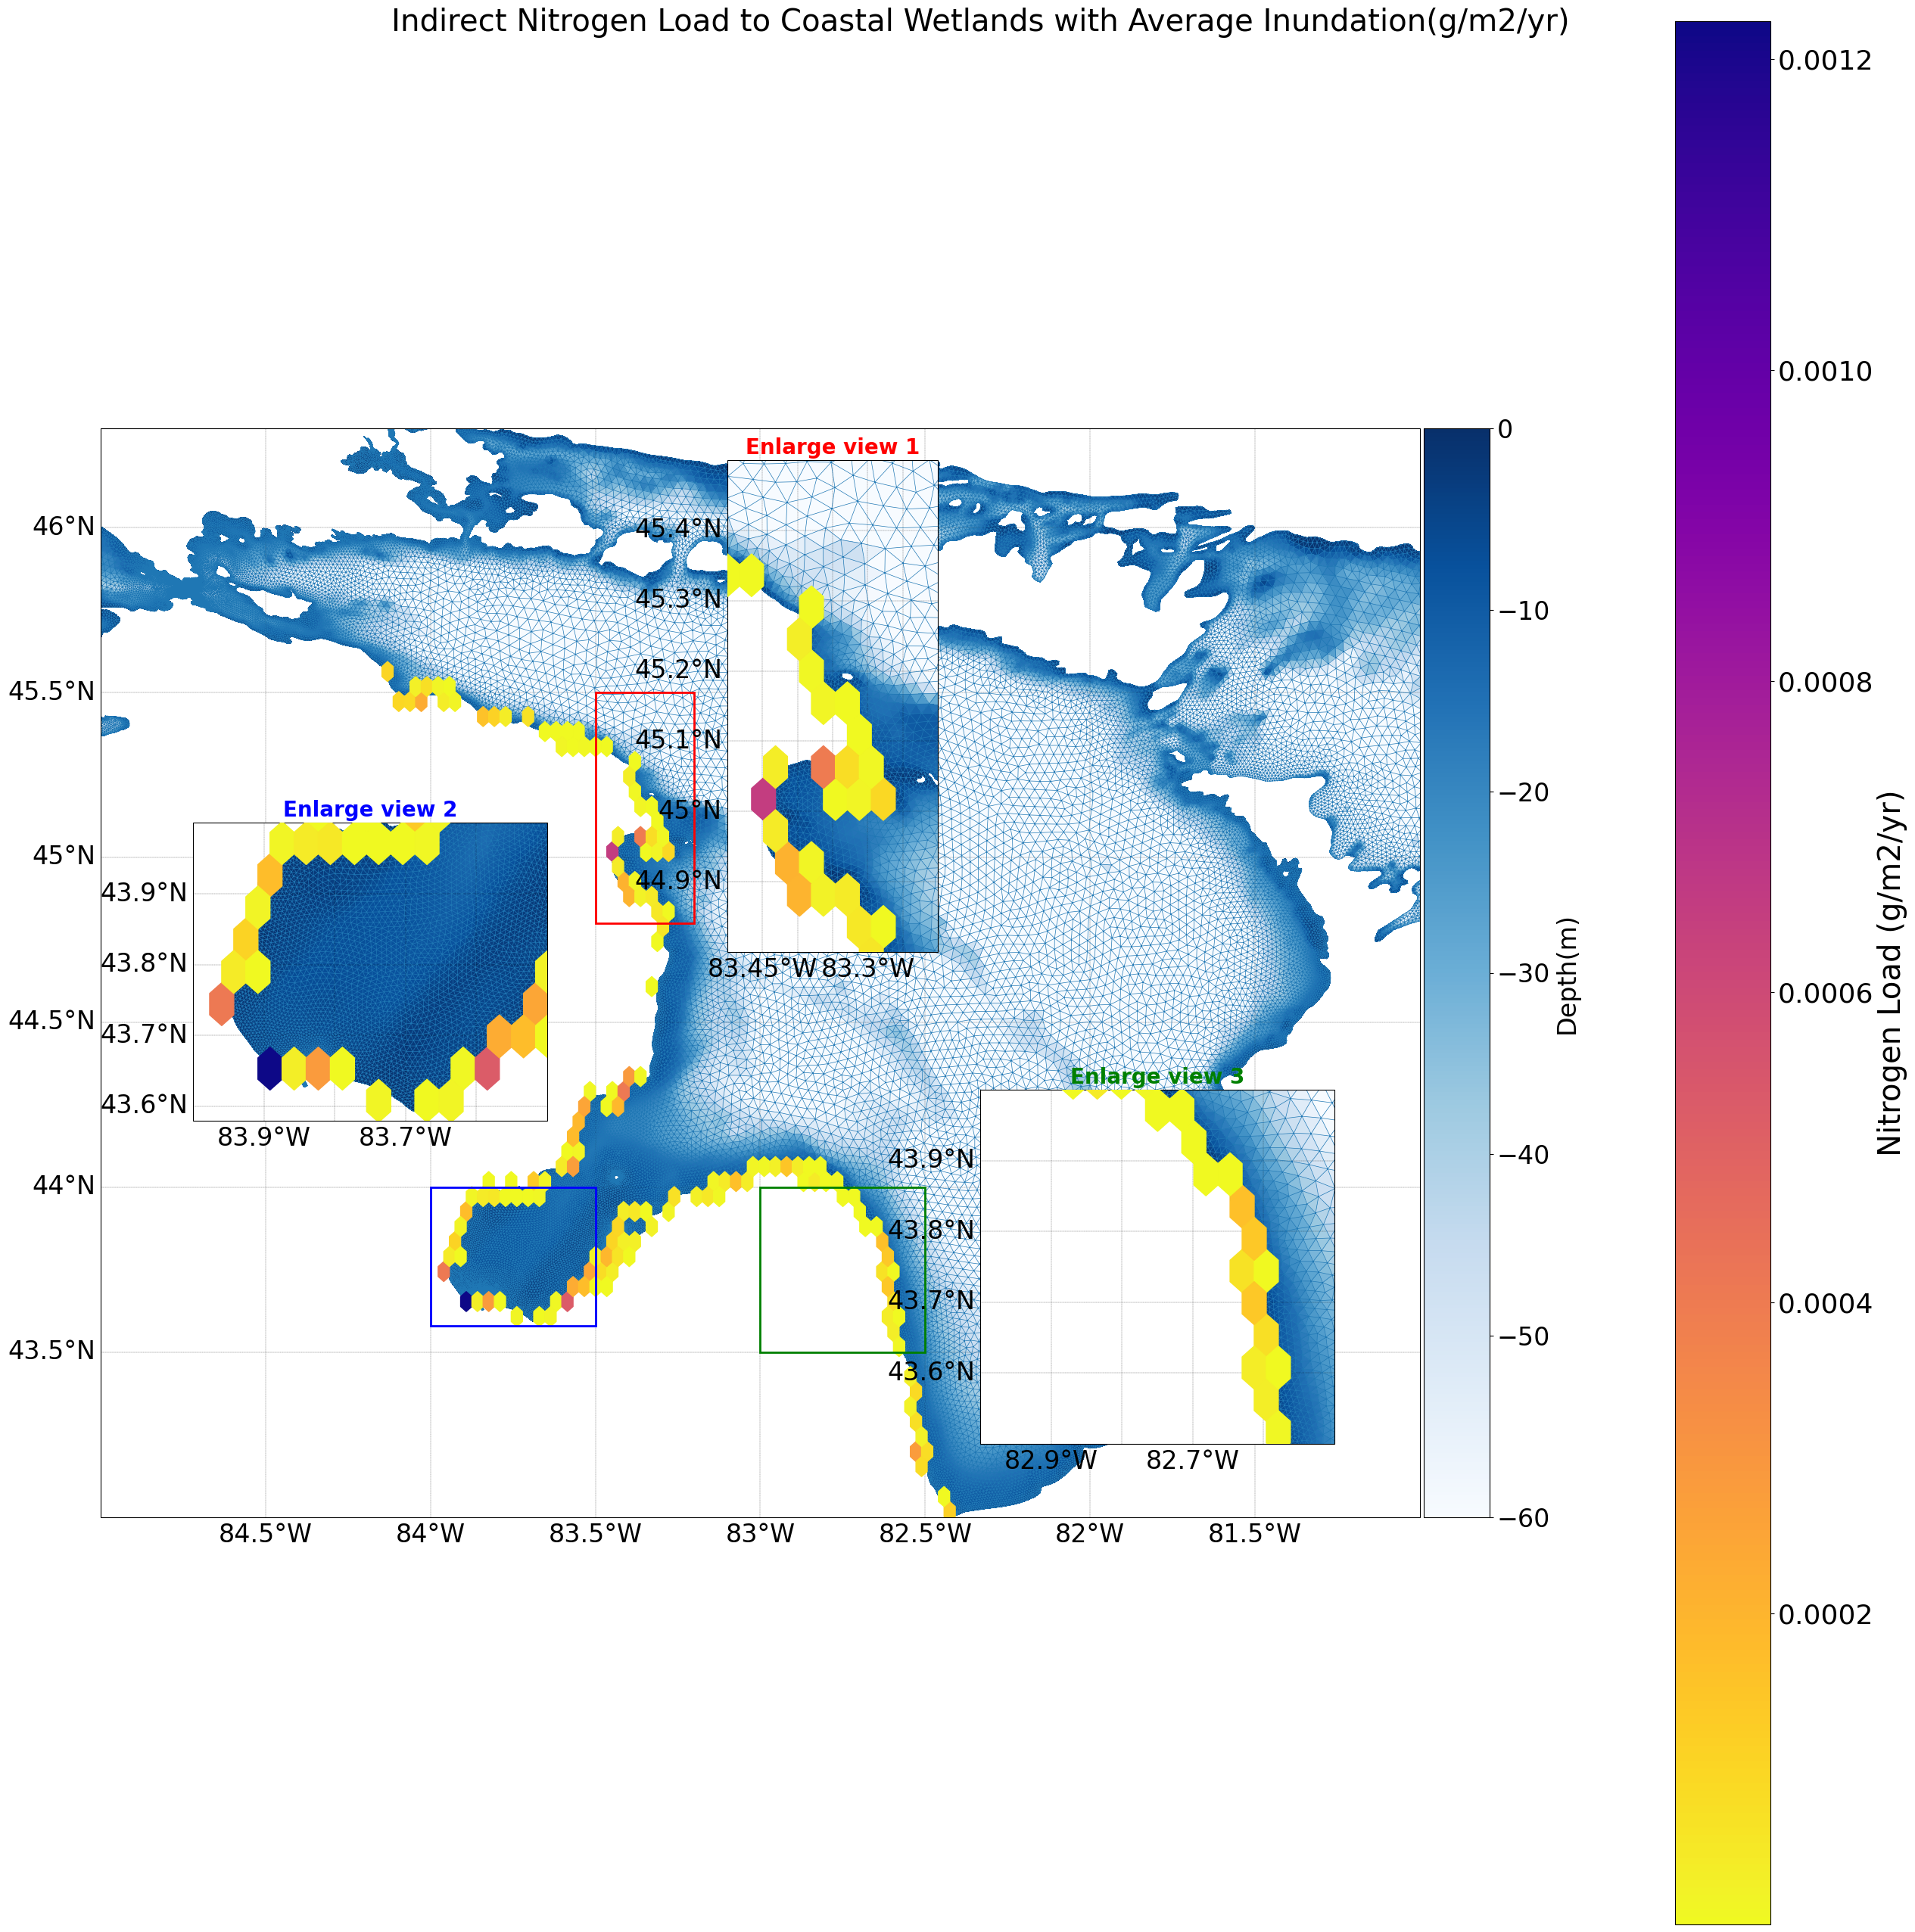

In [97]:
plot_wetload_distribution_TN_with_three_insets(
    merged_data=merged_data_avg,
    grid_metrics_file_name=grid_metrics_file_name,
    main_extents=[275,279,43,46.3],  # Main extent
    zoom_extents_1=[276.5,276.8,44.8,45.5],#zoomed-in extent
    zoom_extents_2=[276.5, 276, 43.58, 44],   # Zoomed-in extent
    zoom_extents_3=[277.5, 277, 43.5, 44],   # Zoomed-in extent
    color_map=reversed_plasma_cmap,  # Colormap for nitrogen
    font_size=24,
    inset_position_1=[0.30, 0.50, 0.25, 0.25],  # [left, bottom, width, height]
    inset_position_2= [0.1, 0.40, 0.18, 0.18],  # [left, bottom, width, height]
    inset_position_3=[0.50, 0.25,0.18, 0.18],  # [left, bottom, width, height]
    colorbar_outside=True,
    title="Indirect Nitrogen Load to Coastal Wetlands with Average Inundation(g/m2/yr)"

)

## PLot monthly Intersections 

In [23]:
def plot_monthly_intersection_barchart(summary_df, title="Monthly % of First-Time Intersections", ax=None):
    summary_df = summary_df.sort_values(by="month")
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(summary_df["month"], summary_df["percentage"], color='skyblue', edgecolor='black')
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.5, f"{height:.1f}%", 
                ha='center', va='bottom', fontsize=10)
    ax.set_xticklabels(summary_df["month"], rotation=45)
    ax.set_ylabel("Intersection Percentage (%) ", fontsize=12)
    ax.set_xlabel("Month", fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.6)


In [20]:
monthly_percentages_df_avg = pd.read_csv(os.path.join(output_path, Intersection_PTCW_Avg_monthly))
monthly_percentages_df_high = pd.read_csv(os.path.join(output_path, Intersection_PTCW_high_monthly))
monthly_percentages_df_low = pd.read_csv(os.path.join(output_path, Intersection_PTCW_low_monthly))
monthly_percentages_df_surge = pd.read_csv(os.path.join(output_path, Intersection_PTCW_surge_monthly))

/tmp/ipykernel_98765/2749993273.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(summary_df["month"], rotation=45)
/tmp/ipykernel_98765/2749993273.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(summary_df["month"], rotation=45)
/tmp/ipykernel_98765/2749993273.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(summary_df["month"], rotation=45)
/tmp/ipykernel_98765/2749993273.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(summary_df["month"], rotation=45)


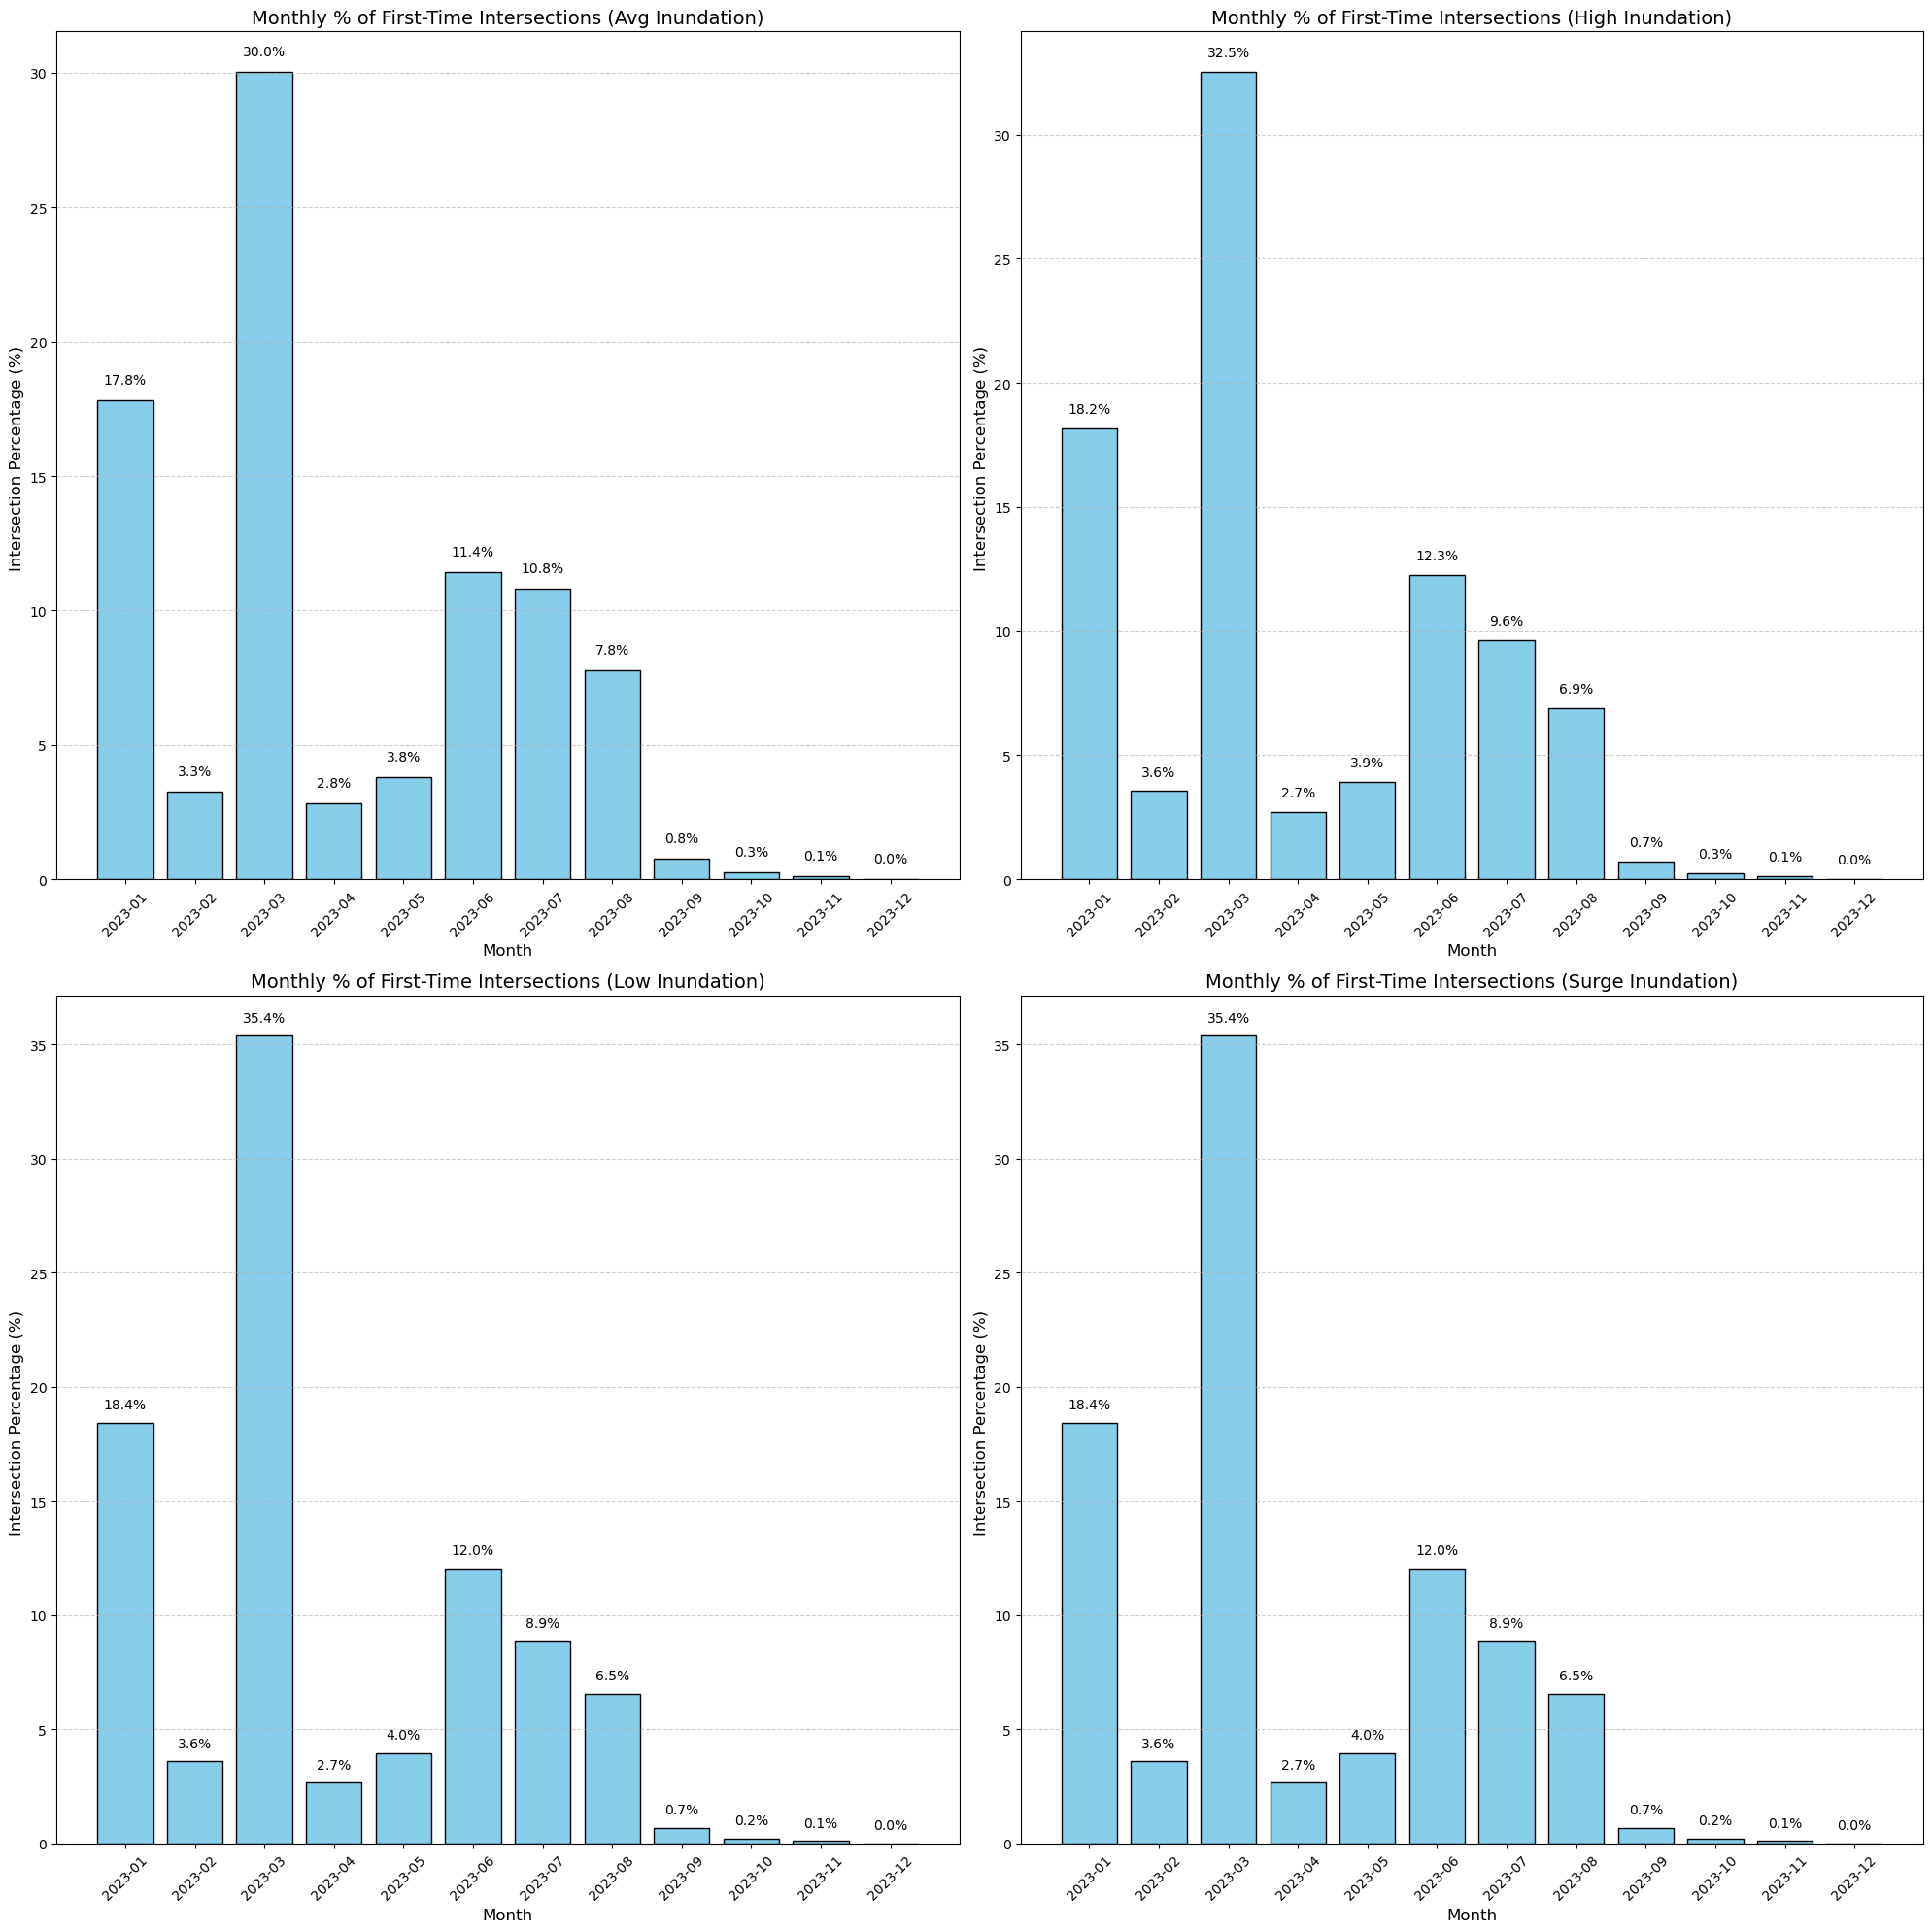

In [24]:
# plot the monthly intersection bar chart 4 of the them avg,high,low,surge in one figure
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
plot_monthly_intersection_barchart(monthly_percentages_df_avg, title="Monthly % of First-Time Intersections (Avg Inundation)", ax=axs[0, 0])
plot_monthly_intersection_barchart(monthly_percentages_df_high, title="Monthly % of First-Time Intersections (High Inundation)", ax=axs[0, 1])
plot_monthly_intersection_barchart(monthly_percentages_df_low, title="Monthly % of First-Time Intersections (Low Inundation)", ax=axs[1, 0])
plot_monthly_intersection_barchart(monthly_percentages_df_surge, title="Monthly % of First-Time Intersections (Surge Inundation)", ax=axs[1, 1])
plt.tight_layout()
plt.savefig(output_figures + '/Monthly_First_Time_Intersections_all_23.png')
plt.show()

In [25]:
output_figures

'/home/abolmaal/modelling/FVCOM/Huron/figures/2024'

In [ ]:
monthly_percentages_df = pd.read_csv(os.path.join(output_path, Intersection_PTCW_Avg_monthly))

In [ ]:
plot_monthly_intersection_barchart(monthly_percentages_df)


In [ ]:
plot_monthly_intersection_barchart(monthly_percentages_df)


In [ ]:
plot_monthly_intersection_barchart(monthly_percentages_df)
